<a href="https://colab.research.google.com/github/preritt/KProj/blob/master/Conv1_Also_TransferRetrainKFiltersInLowAccNw_04242019_K_5New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load standard libraries

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import cifar10
from sklearn import preprocessing
from keras import losses
from keras.models import model_from_json
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [0]:
from keras.utils.vis_utils import plot_model


In [0]:
keras.backend.clear_session()

## Load image data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


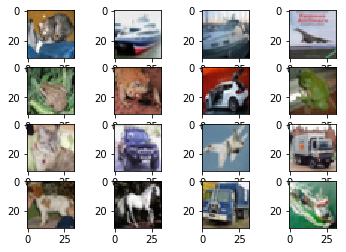

In [4]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.datasets import cifar10
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:16])


## Create Function to get data corresponding to three labels

In [0]:
# This function takes the entire traaining data and test data and corresponding categorical label and returns the corresponding data in class indices
def getThreeClassesTrainTest(class_indices,train_data,train_labels,test_data,test_labels):
  all_train_data = []
  all_train_data_label = []
  all_test_data = []
  all_test_data_label = []
  for ind in class_indices:
    this_class_location_train =  np.where(train_labels==ind)[0] # train_labels[train_labels == ind]
    this_class_data_train = train_data[this_class_location_train,:]
    this_class_data_train_label = train_labels[this_class_location_train]
#     print(this_class_location_train)
    
    this_class_location_test = np.where(test_labels==ind)[0] #test_labels[test_labels == ind]
    this_class_data_test = test_data[this_class_location_test,:]
    this_class_data_test_label = test_labels[this_class_location_test]
    
    all_train_data.append(this_class_data_train)
    all_test_data.append(this_class_data_test)
    all_train_data_label.append(this_class_data_train_label)
    all_test_data_label.append(this_class_data_test_label)
    
  train_data_three = all_train_data[0]
  train_label_three = all_train_data_label[0]
  test_data_three = all_test_data[0]
  test_label_three = all_test_data_label[0]
  
  for j in range(1,len(class_indices)):
    train_data_three = np.concatenate((train_data_three,all_train_data[j]))
    train_label_three = np.concatenate((train_label_three,all_train_data_label[j]))

    test_data_three = np.concatenate((test_data_three,all_test_data[j]))
    test_label_three = np.concatenate((test_label_three,all_test_data_label[j]))
#   print(train_label_three.shape)
  train_label_three = np.reshape(train_label_three,newshape=(-1,))
  test_label_three = np.reshape(test_label_three,newshape=(-1,))
  return train_data_three, train_label_three, test_data_three,test_label_three

## Get data for three classes using getThreeClassesTrainTest function

In [0]:
train_three_data,train_three_label,test_three_data,test_three_label = getThreeClassesTrainTest([ 0,3,5 ],x_train,y_train,x_test,y_test)

(array([5000.,    0.,    0.,    0.,    0.,    0., 5000.,    0.,    0.,
        5000.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

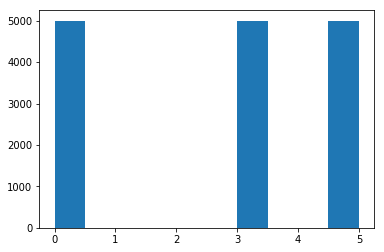

In [7]:
plt.hist(train_three_label)

(array([1000.,    0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,
        1000.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

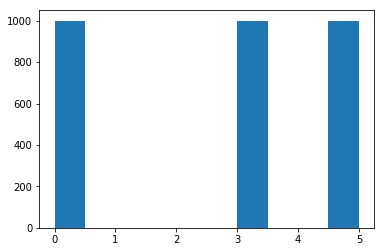

In [8]:
plt.hist(test_three_label)

In [0]:
train_three_data, train_three_label = shuffle(train_three_data, train_three_label )
test_three_data,test_three_label = shuffle(test_three_data,test_three_label )

In [0]:
le = preprocessing.LabelEncoder()
le.fit_transform(train_three_label)
train_three_label_cat = le.transform(train_three_label)
test_three_label_cat = le.transform(test_three_label)
train_three_label_one_hot = to_categorical(train_three_label_cat)
test_three_label_one_hot = to_categorical(test_three_label_cat)

In [0]:
# split train data and to create validation data
train_X,valid_X,train_ground,valid_ground = train_test_split(train_three_data,
                                                             train_three_label_one_hot,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
num_classes = test_three_label_one_hot.shape[1]

## Define the model

In [0]:
x, y = 32, 32
inChannel = 3
input_img = Input(shape = (x, y, inChannel))
ep = 10 
weight_decay = 1e-4

In [0]:
def cifar10Classifier(input_img):
  
  conv1 = (Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:], activation='elu'))(input_img)
  conv1 = BatchNormalization()(conv1)
  conv1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv1)
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
  drop1= Dropout(.2)(pool1)

  conv2 = (Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop1)
  conv2 = BatchNormalization()(conv2)
  conv2 = (Conv2D(64, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv2)
  conv2 = BatchNormalization()(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #14 x 14 x 32
  drop2= Dropout(.3)(pool2)

  conv3 = (Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop2)
  conv3 = BatchNormalization()(conv3)
  conv3 = (Conv2D(128, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv3)
  conv3 = BatchNormalization()(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #14 x 14 x 32
  drop3= Dropout(.4)(pool3)

  flat = Flatten()(drop3)
  out = Dense(num_classes, activation='softmax')(flat)
  
  return out

## Define functions for calculation of DI score
getDIScoreOfLayer(layer_output, true_labels), 
getDIScoreOfLayerCNNLayer(cnn_outputs, true_labels)


In [0]:
def getDIScoreOfLayer(layer_output, true_labels):
  # computeScatterMatrix
  rho = 1e-6
  mu = layer_output.mean(axis=0)
#   print(mu.shape)
  mu = mu.reshape((1,-1))
  centered_data = layer_output - mu
  S_bar = np.matmul(centered_data.T,centered_data)
  # compute between class matrix
  total_classes = true_labels.max()
  S_B = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  S_W = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  unique_classes = np.unique(true_labels)
  unique_classes_list = np.ndarray.tolist(unique_classes)
  for l in unique_classes_list:
    class_l_index = np.where(true_labels == l)
    class_l_output = layer_output[class_l_index[0],:]
    mu_l = class_l_output.mean(axis=0)
    mu_l = mu_l.reshape((1,-1))
    total_examples_this_class = class_l_index[0].shape   
    ss = mu_l - mu
    S_B = S_B + total_examples_this_class*np.matmul((mu_l - mu).T,(mu_l - mu))

  DI_Score = np.trace(np.matmul(np.linalg.inv(S_bar + rho*np.eye(S_bar.shape[0])),S_B))
  return DI_Score

In [0]:
def getDIScoreOfLayerCNNLayer(cnn_outputs, true_labels):
  # computeScatterMatrix
  number_of_filters = cnn_outputs.shape[3]
  cnn_di_scores = []
  for filt in range(0,number_of_filters):
    outputs_filter = cnn_outputs[:,:,:,filt]
    outputs_filter_reshaped = np.reshape(outputs_filter, newshape=(cnn_outputs.shape[0],-1))
    this_filter_score = getDIScoreOfLayer(outputs_filter_reshaped, true_labels)
    cnn_di_scores.append(this_filter_score)
  return cnn_di_scores

## define a function to get and plot di score of a layer. It takes inputs - trained model, layer name to get DI scores and returns a plot with some statistics

In [0]:
def createCNNLayerDIScorePlot(trained_model, layer_name, data_to_use = train_three_data , data_label =train_three_label ):
#   print(trained_model.layers)
#   get_cnn1_output_function = K.function([trained_model.layers[0].input],
#                                   [trained_model.get_layer(layer_name).output])   #get_layer test_three_label
  
  model = trained_model
  intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
  cnn1_output = intermediate_layer_model.predict(data_to_use)
#   cnn1_output = get_cnn1_output_function([data_to_use])[0]
  di_scores = getDIScoreOfLayerCNNLayer(cnn1_output, data_label)
  # plot DI score
  y_pos  = np.arange(len(di_scores))
  plt.bar(y_pos, di_scores, align='center', alpha=0.5)
  plt.xlabel('FilterNumber')
  plt.ylabel('DI Score')

  print('Mean of DI SCore: ',np.mean(di_scores))
  print('STD of DI Score: ', np.std(di_scores))
  print('MAX of DI Score: ', np.max(di_scores))
#   plt.title('DI score - Data - D_L, Network -N_L ' + layer_name)
  plt.title('DI score ' + layer_name)

#   plt.ylim([0,1])
  return di_scores

## load pretrained model

In [18]:
loaded_model_low_accuracy = keras.models.load_model('lowAccuracyModelData.h5')
loaded_model_high_accuracy = keras.models.load_model('highAccuracyModelData.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [19]:
loaded_model_low_accuracy.evaluate(valid_X, valid_ground, verbose=0)

[0.30401611725489297, 0.9103333333333333]

In [20]:
loaded_model_low_accuracy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

## Create a plot for DI score using function createCNNLayerDIScorePlot()

#### On train data

In [0]:
# layer_name = 'conv2d_2'
# model = loaded_model_low_accuracy
# intermediate_layer_model = Model(inputs=model.input,
#                                  outputs=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(train_three_data)

Mean of DI SCore:  0.5925382935503561
STD of DI Score:  0.056698451243603835
MAX of DI Score:  0.6699785350762211


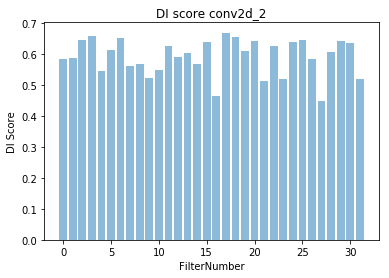

In [21]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'
discores_low_acc_model = createCNNLayerDIScorePlot(loaded_model_low_accuracy, layer_name)

Mean of DI SCore:  0.6055423700151696
STD of DI Score:  0.04535085998146924
MAX of DI Score:  0.7097916612944184


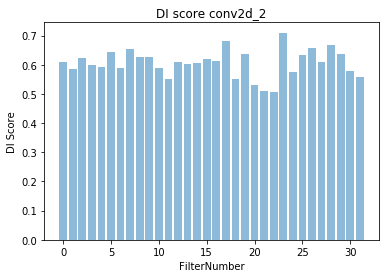

In [22]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'

discores_high_acc_model = createCNNLayerDIScorePlot(loaded_model_high_accuracy, layer_name)

## Pick top 10 DI scores

#### On validation data

In [0]:
valid_ground_actual = np.argmax(valid_ground, axis=1)
# valid_ground_actual.shape
# data_to_use = train_three_data , data_label =train_three_label

Mean of DI SCore:  1.020244246213297
STD of DI Score:  0.04842103810631936
MAX of DI Score:  1.0866383492532292


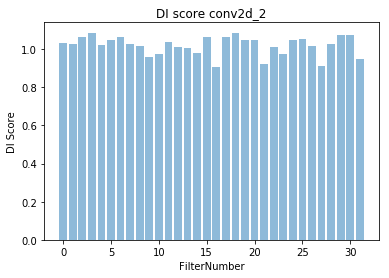

In [24]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'
discores_low_acc_model_valid = createCNNLayerDIScorePlot(loaded_model_low_accuracy,
                                                   layer_name, data_to_use=valid_X, data_label=valid_ground_actual)

Mean of DI SCore:  1.0305711215307305
STD of DI Score:  0.035721789236908476
MAX of DI Score:  1.1067590405295258


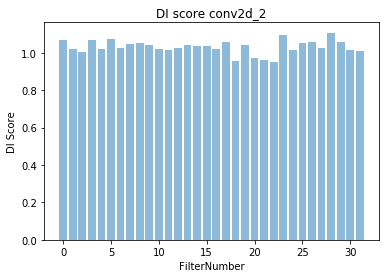

In [31]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'

discores_high_acc_model_valid = createCNNLayerDIScorePlot(loaded_model_high_accuracy,
                                                   layer_name, data_to_use=valid_X, data_label=valid_ground_actual)

In [26]:
np.sort(discores_high_acc_model)

array([0.50778247, 0.51147923, 0.53166066, 0.55036678, 0.55231372,
       0.55683152, 0.57548685, 0.57892867, 0.5844878 , 0.58936378,
       0.58980492, 0.59095896, 0.59923139, 0.60396782, 0.60672473,
       0.60815173, 0.60818269, 0.60875816, 0.61246421, 0.61911564,
       0.62163627, 0.6248541 , 0.62771153, 0.63252964, 0.63513892,
       0.63616836, 0.64202831, 0.65381051, 0.65792047, 0.6686108 ,
       0.68109354, 0.70979166])

In [27]:

# (discores_high_acc_model)
K = 5 # how many channels to pick
high_acc_di_sorted = np.argsort(discores_high_acc_model)
high_acc_di_sorted_list = np.ndarray.tolist(high_acc_di_sorted)
top_channels = high_acc_di_sorted_list[-K:]
top_channels

[7, 26, 28, 17, 23]

#####  get low accuracy DI channels

In [28]:
discores_low_acc_model

[0.5858271513250921,
 0.5874493638811897,
 0.6452765150338297,
 0.6580206770396668,
 0.547363354355855,
 0.6155527932931522,
 0.6532572228131226,
 0.5630031287033164,
 0.5694529267532082,
 0.5236792969202347,
 0.5501762607894927,
 0.6262333015710215,
 0.5906284055089981,
 0.6043863039786268,
 0.5702109369732096,
 0.6395564417927444,
 0.46454864019759956,
 0.6699785350762211,
 0.6559388543386286,
 0.6099727028954384,
 0.6443689539972682,
 0.5125632524401509,
 0.6278863521435074,
 0.5211872374600637,
 0.6398387177343337,
 0.6455079932428873,
 0.5846068952718699,
 0.4499750517893289,
 0.6070204784245227,
 0.6422602590876376,
 0.6363527968760132,
 0.5191445919031645]

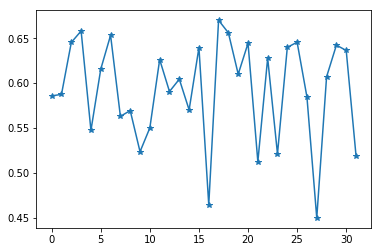

In [29]:
plt.plot(discores_low_acc_model,'-*')

In [30]:
low_acc_di_sorted = np.argsort(discores_low_acc_model)
low_acc_di_sorted_list = np.ndarray.tolist(low_acc_di_sorted)
low_channels = low_acc_di_sorted_list[0:K]
low_channels

[27, 16, 21, 31, 23]

In [0]:
total_channels = len(discores_high_acc_model)
# total_channels

## Now get high DI for Conv1 layer

Mean of DI SCore:  0.45656216093649854
STD of DI Score:  0.10671717978029775
MAX of DI Score:  0.5843963291335272


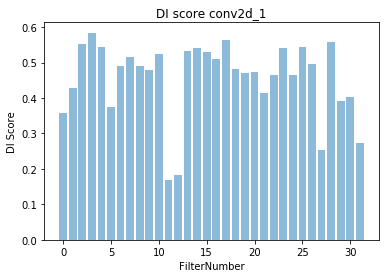

In [35]:
layer_name = 'conv2d_1'
discores_low_acc_model_train_conv1 = createCNNLayerDIScorePlot(loaded_model_low_accuracy,
                                                   layer_name)

Mean of DI SCore:  0.40802925472002327
STD of DI Score:  0.1457609865857832
MAX of DI Score:  0.6506365069472642


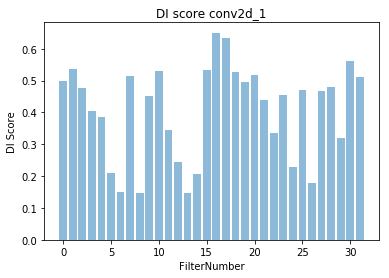

In [36]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_1'

discores_high_acc_model_train_conv1 = createCNNLayerDIScorePlot(loaded_model_high_accuracy,
                                                   layer_name)

In [37]:

# (discores_high_acc_model)
KConv1 = 5 # how many channels to pick
high_acc_di_sorted_conv1 = np.argsort(discores_low_acc_model_train_conv1)
high_acc_di_sorted_list_conv1 = np.ndarray.tolist(high_acc_di_sorted_conv1)
top_channels_conv1 = high_acc_di_sorted_list_conv1[-KConv1:]
top_channels_conv1

[25, 2, 28, 17, 3]

In [38]:
low_acc_di_sorted_conv1 = np.argsort(discores_high_acc_model_train_conv1)
low_acc_di_sorted_list_conv1 = np.ndarray.tolist(low_acc_di_sorted_conv1)
low_channels_conv1 = low_acc_di_sorted_list_conv1[0:KConv1]
low_channels_conv1

[8, 13, 6, 26, 14]

In [0]:
enable_training = True

In [0]:
# returns 
def highAccuracyModelTillConv2(input_img): 
  conv1_1 = (Conv2D(32, (3,3), padding='same',
                    kernel_regularizer=regularizers.l2(weight_decay), 
                    input_shape=x_train.shape[1:], activation='elu', trainable = enable_training,
                    name = 'HighAccuracyConv1'))(input_img)
  conv1_2 = BatchNormalization(name = 'HighAccuracyBN1',
                              trainable = enable_training)(conv1_1)
  conv2_1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',trainable = enable_training,
                    name = 'HighAccuracyConv2',kernel_regularizer=regularizers.l2(weight_decay)))(conv1_2)
#   conv2_2 = BatchNormalization(name = 'HighAccuracyBN2',
#                               trainable = enable_training)(conv2_1)  
  
  return conv2_1

In [0]:
from keras.layers import Dense, Concatenate, Input, Lambda


In [0]:
import tensorflow as tf
def cifar10ClassifierTransfer(input_img, conv2_high):
  
  # Add additional inputs to 
  
  conv1_1 = (Conv2D(32, (3,3), padding='same',name = 'lowAccuracyModelConv1_1',
                    trainable = enable_training, kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:], activation='elu'))(input_img)
  conv1_2 = BatchNormalization(name = 'lowAccuracyModelBN1',
                              trainable = enable_training)(conv1_1)
  conv2_1 = (Conv2D(32, (3,3), padding='same',name = 'lowAccuracyModelConv2_1',
                    trainable = enable_training, activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv1_2)
#   channels = top_channels
#   branch_outputs = []
# #   orig_channel = conv2_1
#   # create a mask here
#   branch_outputs.append(conv2_1)
#   for i in channels:
#       # Slicing the ith channel:
#       out = Lambda(lambda x: x[:,:,:, i])(conv2_high)      
#       # Setting up your per-channel layers (replace with actual sub-models):
#       layer_out = Lambda(lambda x: keras.backend.expand_dims(x, axis = 3))(out)
#       branch_outputs.append(layer_out)
#   merged = Concatenate()(branch_outputs)


  conv2_2 = BatchNormalization()(conv2_1)
  pool2_3 = MaxPooling2D(pool_size=(2, 2))(conv2_2) #14 x 14 x 32
  drop2_4= Dropout(.2)(pool2_3)

  conv3_1 = (Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop2_4)
  conv3_2 = BatchNormalization()(conv3_1)
  conv4_1 = (Conv2D(64, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv3_2)
  conv4_2 = BatchNormalization()(conv4_1)
  pool4_3 = MaxPooling2D(pool_size=(2, 2))(conv4_2) #14 x 14 x 32
  drop4_4= Dropout(.3)(pool4_3)

  conv5_1 = (Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop4_4)
  conv5_2 = BatchNormalization()(conv5_1)
  conv6_1 = (Conv2D(128, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv5_2)
  conv6_2 = BatchNormalization()(conv6_1)
  pool6_3 = MaxPooling2D(pool_size=(2, 2))(conv6_2) #14 x 14 x 32
  drop6_4= Dropout(.4)(pool6_3)

  flat = Flatten()(drop6_4)
  out = Dense(num_classes, activation='softmax')(flat)
  
  return out

In [43]:
top_channels

[7, 26, 28, 17, 23]

In [44]:
high_acc_output = highAccuracyModelTillConv2(input_img)
modelFilt = Model(input_img, 
              cifar10ClassifierTransfer(input_img,
              high_acc_output))
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_three_data)
 
#training
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

modelFilt.compile(loss=losses.categorical_crossentropy, optimizer=opt_rms, metrics=['accuracy'])

modelFilt.summary()
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lowAccuracyModelConv1_1 (Con (None, 32, 32, 32)        896       
_________________________________________________________________
lowAccuracyModelBN1 (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
lowAccuracyModelConv2_1 (Con (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

In [0]:
plot_model(modelFilt, to_file="FiltModel.png", show_shapes=True, show_layer_names=True)

In [46]:
loaded_model_high_accuracy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

## set predetermined weights

In [47]:
top_channels

[7, 26, 28, 17, 23]

In [48]:
top_channels

[7, 26, 28, 17, 23]

#### # get low accuracy DI channel - stored in low_channels

```
# This is formatted as code
```

s

In [49]:

loaded_model_high_accuracy.get_layer('conv2d_2').get_weights()[0].shape

(3, 3, 32, 32)

## Get filter weights for top K10 DI scores

#### Get weight of conv1 layer

In [0]:
# set weights of high accuracy model for channels not used to 0 [9, 25, 19, 29, 5, 7, 26, 28, 17, 23]
high_acc_conv1_weights = loaded_model_high_accuracy.get_layer('conv2d_1').get_weights()
# temp_weights = np.zeros_like(high_acc_conv2_weights[0].shape[0])
temp_weights_top_10_DI_conv1 = np.zeros(shape = (high_acc_conv1_weights[0].shape[0],high_acc_conv1_weights[0].shape[1],high_acc_conv1_weights[0].shape[2],KConv1))
h,w,d,n = high_acc_conv1_weights[0].shape
j = 0
for ch in range(0,n):
  if ch in top_channels_conv1:
    temp_weights_top_10_DI_conv1[:,:,:,j] = high_acc_conv1_weights[0][:,:,:,ch]
    j = j+1

In [0]:
temp_bias_top_10_DI_conv1 = np.zeros(shape = (KConv1,))
# temp_bias = high_acc_conv2_weights[1]

# bias_shape = high_acc_conv2_weights[1].shape
j = 0
for ch in range(0,high_acc_conv1_weights[1].shape[0]):
#   print (ch)
  if ch in top_channels_conv1:
    temp_bias_top_10_DI_conv1[j] = high_acc_conv1_weights[1][ch]
    j = j+1

#### Get weights of conv2 layer

In [0]:
# set weights of high accuracy model for channels not used to 0 [9, 25, 19, 29, 5, 7, 26, 28, 17, 23]
high_acc_conv2_weights = loaded_model_high_accuracy.get_layer('conv2d_2').get_weights()
# temp_weights = np.zeros_like(high_acc_conv2_weights[0].shape[0])
temp_weights_top_10_DI = np.zeros(shape = (high_acc_conv2_weights[0].shape[0],high_acc_conv2_weights[0].shape[1],high_acc_conv2_weights[0].shape[2],K))
h,w,d,n = high_acc_conv2_weights[0].shape
j = 0
for ch in range(0,n):
  if ch in top_channels:
    temp_weights_top_10_DI[:,:,:,j] = high_acc_conv2_weights[0][:,:,:,ch]
    j = j+1
    
  
# (high_acc_conv2_weights[0].shape)

In [0]:
temp_weights_top_10_DI.shape

(3, 3, 32, 5)

In [0]:
top_channels

[7, 26, 28, 17, 23]

In [0]:
temp_bias_top_10_DI = np.zeros(shape = (K,))
# temp_bias = high_acc_conv2_weights[1]

# bias_shape = high_acc_conv2_weights[1].shape
j = 0
for ch in range(0,high_acc_conv2_weights[1].shape[0]):
#   print (ch)
  if ch in top_channels:
    temp_bias_top_10_DI[j] = high_acc_conv2_weights[1][ch]
    j = j+1

In [0]:
# temp_bias
weights_to_assign_fromHighAcc = [temp_weights_top_10_DI,temp_bias_top_10_DI]

In [0]:
weights_to_assign_fromHighAccConv1 = [temp_weights_top_10_DI_conv1,temp_bias_top_10_DI_conv1]

In [0]:
temp_weights_top_10_DI.shape

(3, 3, 32, 5)

In [0]:
high_acc_conv2_weights[1].shape

(32,)

In [0]:
# modelFilt.get_layer('lowAccuracyModelConv1_1').set_weights(loaded_model_low_accuracy.get_layer('conv2d_1').get_weights())
# modelFilt.get_layer('lowAccuracyModelBN1').set_weights(loaded_model_low_accuracy.get_layer('batch_normalization_1').get_weights())
# # modelFilt.get_layer('HighAccuracyConv2').set_weights(loaded_model_high_accuracy.get_layer('conv2d_2').get_weights())
# modelFilt.get_layer('lowAccuracyModelConv2_1').set_weights(loaded_model_low_accuracy.get_layer('conv2d_2').get_weights())

In [57]:
loaded_model_low_accuracy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

In [0]:
# preset the weights
for l1,l2 in zip(modelFilt.layers,loaded_model_low_accuracy.layers):
    l1.set_weights(l2.get_weights())

#### Update weights of conv1 layer

In [0]:
low_acc_conv2d_weights_bias = modelFilt.get_layer('lowAccuracyModelConv2_1').get_weights()
low_acc_conv2d_weights = low_acc_conv2d_weights_bias[0]
low_acc_conv2d_wbias= low_acc_conv2d_weights_bias[1]


In [0]:
temp_bias_top_10_DI.shape

(5,)

In [0]:
# now change weights for layers corresponding to lowest DI scores
orig_weights = np.copy(low_acc_conv2d_weights)
j = 0
for ch in range(0,orig_weights.shape[3]):
  if ch in low_channels:
#     print(ch)
    orig_weights[:,:,:,ch] = temp_weights_top_10_DI[:,:,:,j]
    j = j+1
# orig_weights.shape

In [0]:
orig_bias = np.copy(low_acc_conv2d_wbias)
j = 0
for ch in range(0,orig_bias.shape[0]):
  if ch in low_channels:
#     print(ch)
    orig_bias[ch] = temp_bias_top_10_DI[j]
    j = j+1

In [0]:
new_wt_bias_conv2d1 = [orig_weights,orig_bias]

In [0]:
modelFilt.get_layer('lowAccuracyModelConv2_1').set_weights(new_wt_bias_conv2d1)

#### Update weights of conv1 layer

In [0]:
low_acc_conv2d_weights_bias_conv1 = modelFilt.get_layer('lowAccuracyModelConv1_1').get_weights()
low_acc_conv2d_weights_conv1 = low_acc_conv2d_weights_bias_conv1[0]
low_acc_conv2d_wbias_conv1= low_acc_conv2d_weights_bias_conv1[1]


In [0]:
# now change weights for layers corresponding to lowest DI scores
orig_weights_conv1 = np.copy(low_acc_conv2d_weights_conv1)
j = 0
for ch in range(0,orig_weights_conv1.shape[3]):
  if ch in low_channels_conv1:
#     print(ch)
    orig_weights_conv1[:,:,:,ch] = temp_weights_top_10_DI_conv1[:,:,:,j]
    j = j+1
# orig_weights.shape

In [0]:
orig_bias_conv1 = np.copy(low_acc_conv2d_wbias_conv1)
j = 0
for ch in range(0,orig_bias_conv1.shape[0]):
  if ch in low_channels_conv1:
#     print(ch)
    orig_bias_conv1[ch] = temp_bias_top_10_DI_conv1[j]
    j = j+1

In [0]:
new_wt_bias_conv2d1_conv1 = [orig_weights_conv1,orig_bias_conv1]

In [0]:
modelFilt.get_layer('lowAccuracyModelConv1_1').set_weights(new_wt_bias_conv2d1_conv1)

#### Overwrite weights fow low DI with high DI

In [0]:
loaded_model_low_accuracy.layers[5]

In [0]:
modelFilt.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lowAccuracyModelConv1_1 (Con (None, 32, 32, 32)        896       
_________________________________________________________________
lowAccuracyModelBN1 (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
lowAccuracyModelConv2_1 (Con (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

#### # now replace weights in conv2d layer for filters correspondng to lowest 10 DI scores

In [0]:
mcp_save = ModelCheckpoint('weights.hdf5', save_best_only=True, monitor='val_acc', mode='auto')

In [0]:
def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [71]:
modelFilt.fit_generator(datagen.flow(train_X, train_ground, batch_size=batch_size),\
                    steps_per_epoch=train_X.shape[0] // batch_size,epochs=60,\
                    verbose=1,validation_data=(valid_X,valid_ground),
                    shuffle = True,callbacks=[mcp_save,LearningRateScheduler(lr_schedule)])

Epoch 1/60
187/187 [==============================] - 8s 44ms/step - loss: 0.4023 - acc: 0.8631 - val_loss: 0.3302 - val_acc: 0.8997
Epoch 2/60
187/187 [==============================] - 6s 33ms/step - loss: 0.3882 - acc: 0.8694 - val_loss: 0.3047 - val_acc: 0.9113
Epoch 3/60
187/187 [==============================] - 6s 33ms/step - loss: 0.3634 - acc: 0.8802 - val_loss: 0.3042 - val_acc: 0.9097
Epoch 4/60
187/187 [==============================] - 6s 33ms/step - loss: 0.3512 - acc: 0.8873 - val_loss: 0.2855 - val_acc: 0.9207
Epoch 5/60
187/187 [==============================] - 6s 33ms/step - loss: 0.3415 - acc: 0.8876 - val_loss: 0.2986 - val_acc: 0.9150
Epoch 6/60
187/187 [==============================] - 6s 33ms/step - loss: 0.3420 - acc: 0.8915 - val_loss: 0.2982 - val_acc: 0.9177
Epoch 7/60
187/187 [==============================] - 6s 33ms/step - loss: 0.3294 - acc: 0.8939 - val_loss: 0.2811 - val_acc: 0.9223
Epoch 8/60
187/187 [==============================] - 6s 33ms/step - 

In [0]:
modelFilt.load_weights('weights.hdf5')

In [0]:
modelFilt.save('TransferredHiDINoParameterInc_conv1_conv2_K10_KConv1_10.h5')


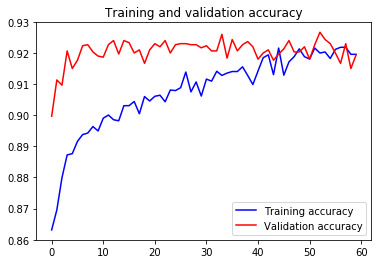

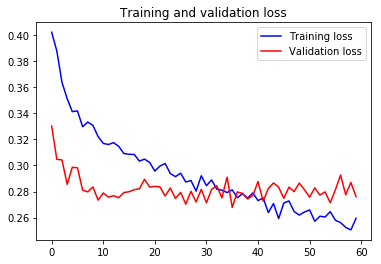

In [74]:
accuracy = modelFilt.history.history['acc']
val_accuracy = modelFilt.history.history['val_acc']
loss = modelFilt.history.history['loss']
val_loss = modelFilt.history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [75]:
modelFilt.evaluate(valid_X, valid_ground, verbose=0)

[0.27727277628580727, 0.9266666666666666]

In [76]:
#testing
test_eval = modelFilt.evaluate(test_three_data, test_three_label_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.3229013578891754
Test accuracy: 0.9019999998410543


Mean of DI SCore:  0.4503011143130983
STD of DI Score:  0.11165312134268869
MAX of DI Score:  0.640854296250408


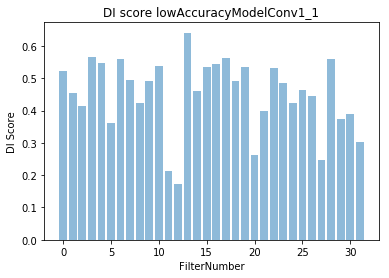

In [77]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'lowAccuracyModelConv1_1'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

Mean of DI SCore:  0.6079696233731384
STD of DI Score:  0.04905920817523011
MAX of DI Score:  0.6777911394061237


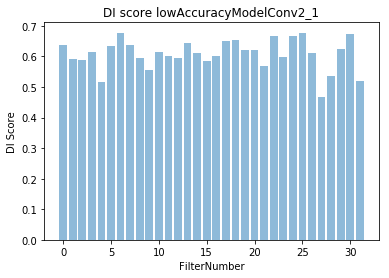

In [78]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'lowAccuracyModelConv2_1'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

Mean of DI SCore:  0.517795047097889
STD of DI Score:  0.08040273437443898
MAX of DI Score:  0.6827157487122428


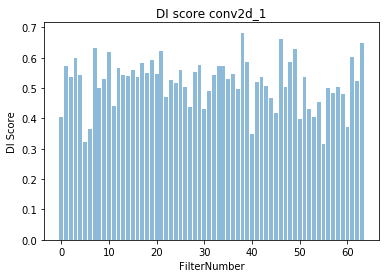

In [79]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_1'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

Mean of DI SCore:  0.539073443555204
STD of DI Score:  0.07192714277865916
MAX of DI Score:  0.6668707050716032


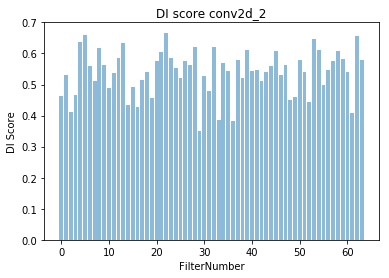

In [80]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

Mean of DI SCore:  0.43628084873176065
STD of DI Score:  0.10409734879102296
MAX of DI Score:  0.7217885423544547


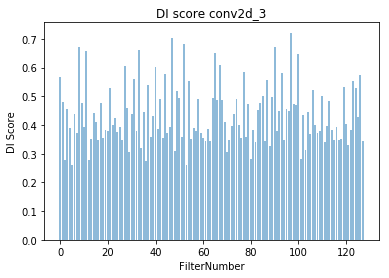

In [81]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_3'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

In [0]:
# # now get DI score of a layer from high accuracy and low accuracy model
# layer_name = 'conv2d_4'
# discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)
# plt.title('Temp')

Mean of DI SCore:  0.483328353826185
STD of DI Score:  0.12543630074198264
MAX of DI Score:  0.8788158943182016


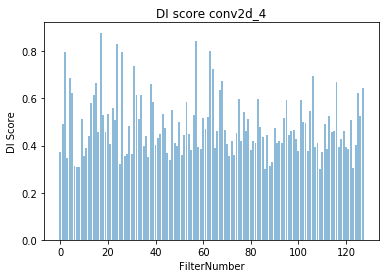

In [83]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_4'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

In [84]:
modelFilt.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lowAccuracyModelConv1_1 (Con (None, 32, 32, 32)        896       
_________________________________________________________________
lowAccuracyModelBN1 (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
lowAccuracyModelConv2_1 (Con (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________